In [102]:
import sys
sys.path.append("../../")

%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import rc
from scipy.interpolate import interp1d
from scipy.integrate import quad, romberg, fixed_quad, quadrature

from axion_kSZ_source.axion_camb_wrappers.run_axion_camb import AxionCAMBWrapper
from axion_kSZ_source.theory.cosmology import Cosmology,CosmologyCustomH
from axion_kSZ_source.theory.sigma_interpolation import SigmaInterpolator
from axion_kSZ_source.theory.sigma_interpolation_FFTLog import SigmaInterpolatorFFTLog
from axion_kSZ_source.auxiliary.integration_helper import IntegrationHelper
from axion_kSZ_source.auxiliary.window_functions import WindowFunctions
from axion_kSZ_source.theory.eli_mass_functions import EliMassFunction
from axion_kSZ_source.theory.eli_mass_functions import BubbleMassFunction
from axion_kSZ_source.theory.halo_bias_new import HaloBias
from axion_kSZ_source.theory.correlation_functions import CorrelationFunctions
from axion_kSZ_source.theory.correlation_functions_FFTLog import CorrelationFunctions as CorrelationFunctionsFFTLog

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [103]:
plt.rc('font',**{'family':'serif','serif':['Palatino']})
plt.rc('text', usetex=True)
#plt.mathtext.rcParams['legend.fontsize']='medium'
plt.rcParams["figure.figsize"] = [8.0,6.0]
axislabelfontsize='large'
matplotlib.mathtext.rcParams['legend.fontsize']='medium'


matplotlib.rcParams['font.family'] = 'Times New Roman'

rc("axes", linewidth=2.0)
rc("lines", markeredgewidth=4)
rc('xtick', labelsize = 20)
rc('ytick', labelsize = 20)

fig_width_pt = 703.27 #513.17           # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inches
golden_mean=0.9
fig_width = fig_width_pt*inches_per_pt  # width in inches
fig_height =fig_width*golden_mean       # height in inches
fig_size = [fig_width,fig_height]
#
params = {'backend': 'pdf',
             'axes.labelsize': 14,
             'lines.markersize': 4,
             'font.size': 14,
             'xtick.major.size':6,
             'xtick.minor.size':3,
             'ytick.major.size':6,
             'ytick.minor.size':3,
             'xtick.major.width':0.5,
             'ytick.major.width':0.5,
             'xtick.minor.width':0.5,
             'ytick.minor.width':0.5,
             'lines.markeredgewidth':1,
             'axes.linewidth':1.2,
             'xtick.labelsize': 14,
             'ytick.labelsize': 14,
             'savefig.dpi':2000,
   #      'path.simplify':True,
   #      'font.family': 'serif',
   #      'font.serif':'Times',
             'text.usetex':True,
             'text.latex.preamble': [r'\usepackage{amsmath}'],
             'figure.figsize': fig_size}

plt.rcParams.update(params)

/home/emelnick/anaconda3/lib/python3.9/_collections_abc.py:941: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


# Table of Contents
1. [Cosmology](#cosmo)
    1. [Cosmology Functions](#cosmo_functions)
    1. [Cosmologies](#cosmologies)
1. [Plots and Bubble Work](#plots)
1. [Testing, Scratch, and Junk](#test)

# 1. Cosmology <a name="cosmo"></a>

Everything that is evaluated for a certain cosmology is stored in the various arrays below, and anytime a cosmology is updated or added, the changes to the arrays should be computed automatically, so they can be called easily and consistently at any time

### A. Cosmology functions<a name="cosmo_functions"></a>

Reset the cosmology arrays by running this cell or by calling `reset_cosmo()`

In [21]:
cosmos = []
camb = []
lin_power = []
growth = []
sigmaInt = []
sigmaIntFFT = []
bubbleFunc = []
bubbleFuncFFT = []
pressSchechter = []
pressSchechterFFT = []

window = 'sharp_k'
intHelper = IntegrationHelper(2048)
z_vals_sigma = np.linspace(0,20,25) 
                                # I'm not sure what to do for this one; I don't know what Gerrit used for this.
                                # The earliest example of 'z_vals' in the other notebook is np.linspace(0,6.5,8),
                                # which is what sigmaInt would use if all the cells in that notebook were ran in
                                # order, but that doesn't seem like a large enough range.

def reset_cosmo():
    global cosmos, lin_power,growth,sigmaInt,sigmaIntFFT,bubbleFunc,bubbleFuncFFT,pressSchechter,pressSchechterFFT
    
    cosmos = []
    camb = []
    lin_power = []
    growth = []
    sigmaInt = []
    sigmaIntFFT = []
    bubbleFunc = []
    bubbleFuncFFT = []
    pressSchechter = []
    pressSchechterFFT = []
    
    window = 'sharp_k'
    intHelper = IntegrationHelper(2048)
    z_vals_sigma = np.linspace(0,20,25) 
                                    # I'm not sure what to do for this one; I don't know what Gerrit used for this.
                                    # The earliest example of 'z_vals' in the other notebook is np.linspace(0,6.5,8),
                                    # which is what sigmaInt would use if all the cells in that notebook were ran in
                                    # order, but that doesn't seem like a large enough range.
    

Functions to add a new cosmology/update the cosmology array. Make sure these have been run before adding/changing any cosmologies.

In [22]:
def add_cosmo(cosmo,name): # Adds a new cosmology to the arrays. Returns the cosmology array index
        
    cid = len(cosmos)
    
    outpath = "./sigma_tests/"
    fileroot ="test_"+name
    log_path = outpath+"sigma_test_"+name+"_log.log"

    thisCamb = AxionCAMBWrapper(outpath, fileroot, log_path)
    thisCamb(cosmo)
    camb.append(thisCamb)
    cosmo.set_H_interpolation(thisCamb)
    
    lin_power.append(thisCamb.get_linear_power(extrap_kmax=1e3, extrap_kmin=1e-6))
    growth.append(thisCamb.get_growth())
    
    thisSigmaInt = SigmaInterpolator(cosmo,lin_power[cid],growth[cid],1e1,1e20,z_vals_sigma,intHelper,Nr=1024,window_function=window)
    thisSigmaInt.compute(1e-4,1e3)
    sigmaInt.append(thisSigmaInt)
    
    thisSigmaIntFFT =  SigmaInterpolatorFFTLog(cosmo, lin_power[cid], growth[cid], z_vals_sigma, 1e-4, 1e3, Nr=1024, window_function=window)
    thisSigmaIntFFT.compute()
    sigmaIntFFT.append(thisSigmaIntFFT)
    
    bubbleFunc.append(BubbleMassFunction(cosmo,thisSigmaInt))
    bubbleFuncFFT.append(BubbleMassFunction(cosmo,thisSigmaIntFFT))
    
    pressSchechter.append(EliMassFunction(cosmo,thisSigmaInt))
    pressSchechterFFT.append(EliMassFunction(cosmo,thisSigmaIntFFT))
    
    cosmos.append(cosmo)
    
    return cid

def update_cosmo(cosmo,i): # Updates the arrays' ith position with cosmo
    
    thisCamb = camb[i]
    thisCamb(cosmo)
    camb[i] = thisCamb
    cosmo.set_H_interpolation(thisCamb)

    lin_power[i] = thisCamb.get_linear_power(extrap_kmax=1e3, extrap_kmin=1e-6)
    growth[i] = thisCamb.get_growth()
    
    thisSigmaInt = SigmaInterpolator(cosmo,lin_power[i],growth[i],1e1,1e20,z_vals_sigma,intHelper,Nr=1024,window_function=window)
    thisSigmaInt.compute(1e-4,1e3)
    sigmaInt[i] = thisSigmaInt
    
    thisSigmaIntFFT =  SigmaInterpolatorFFTLog(cosmo, lin_power[i], growth[i], z_vals_sigma, 1e-4, 1e3, Nr=1024, window_function=window)
    thisSigmaIntFFT.compute()
    sigmaIntFFT[i] = thisSigmaIntFFT
    
    bubbleFunc[i] = BubbleMassFunction(cosmo,thisSigmaInt)
    bubbleFuncFFT[i] = BubbleMassFunction(cosmo,thisSigmaIntFFT)
    
    pressSchechter[i] = EliMassFunction(cosmo,thisSigmaInt)
    pressSchecterFFT[i] = EliMassFunction(cosmo,thisSigmaIntFFT)
    
    cosmos[i] = cosmo
    
    return 1

### B. Cosmologies<a name='cosmologies'></a>

Change the parameters at the beginning of the cell to update an existing cosmology, or add a new cell in the same style to add a new cosmology. Run the cell to update/add the cosmology.

In [23]:
# cosmo0

m_ax = 1e-26
ax_frac = 0.005
h_param = 0.72
rhff = True

newCosmo0 = [m_ax,ax_frac,h_param,rhff]
try:
    oldCosmo0
except NameError:
    oldCosmo0 = newCosmo0
    try:
        cosmo0
    except NameError:
        cosmo0 = Cosmology.generate(m_axion=m_ax,axion_frac=ax_frac,h=h_param,read_H_from_file=rhff)
        add_cosmo(cosmo0,'cosmo0')
    else:
        try:
            i = cosmos.index(cosmo0)
        except ValueError:
            add_cosmo(cosmo0,'cosmo0')
        else:
            cosmo0 = Cosmology.generate(m_axion=m_ax,axion_frac=ax_frac,h=h_param,read_H_from_file=rhff)
            update_cosmo(cosmo0,i)
else:
    try:
        cosmo0
    except NameError:
        cosmo0 = Cosmology.generate(m_axion=m_ax,axion_frac=ax_frac,h=h_param,read_H_from_file=rhff)
        add_cosmo(cosmo0,'cosmo0')
    else: 
        try:
            i = cosmos.index(cosmo0)
        except ValueError:
            if not oldCosmo0 == newCosmo0:
                cosmo0 = Cosmology.generate(m_axion=m_ax,axion_frac=ax_frac,h=h_param,read_H_from_file=rhff)
            add_cosmo(cosmo0,'cosmo0')
        else :
            if not oldCosmo0 == newCosmo0:
                cosmo0 = Cosmology.generate(m_axion=m_ax,axion_frac=ax_frac,h=h_param,read_H_from_file=rhff)
                update_cosmo(cosmo0,i)

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG IEEE_DIVIDE_BY_ZERO IEEE_UNDERFLOW_FLAG IEEE_DENORMAL
/home/emelnick/anaconda3/lib/python3.9/site-packages/mcfit/mcfit.py:126: UserWarning: The default value of lowring has been changed to False, set it to True if you cannot reproduce previous results
  warnings.warn("The default value of lowring has been changed to False, "


In [24]:
# cosmo1

m_ax = 1e-26
ax_frac = 0.05
h_param = 0.72
rhff = True

newCosmo1 = [m_ax,ax_frac,h_param,rhff]
try:
    oldCosmo1
except NameError:
    oldCosmo1 = newCosmo1
    try:
        cosmo1
    except NameError:
        cosmo1 = Cosmology.generate(m_axion=m_ax,axion_frac=ax_frac,h=h_param,read_H_from_file=rhff)
        add_cosmo(cosmo1,'cosmo1')
    else:
        try:
            i = cosmos.index(cosmo1)
        except ValueError:
            add_cosmo(cosmo1,'cosmo1')
        else:
            cosmo1 = Cosmology.generate(m_axion=m_ax,axion_frac=ax_frac,h=h_param,read_H_from_file=rhff)
            update_cosmo(cosmo1,i)
else:
    try:
        cosmo1
    except NameError:
        cosmo1 = Cosmology.generate(m_axion=m_ax,axion_frac=ax_frac,h=h_param,read_H_from_file=rhff)
        add_cosmo(cosmo1,'cosmo1')
    else: 
        try:
            i = cosmos.index(cosmo1)
        except ValueError:
            if not oldCosmo1 == newCosmo1:
                cosmo1 = Cosmology.generate(m_axion=m_ax,axion_frac=ax_frac,h=h_param,read_H_from_file=rhff)
            add_cosmo(cosmo1,'cosmo1')
        else :
            if not oldCosmo1 == newCosmo1:
                cosmo1 = Cosmology.generate(m_axion=m_ax,axion_frac=ax_frac,h=h_param,read_H_from_file=rhff)
                update_cosmo(cosmo1,i)

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG IEEE_DIVIDE_BY_ZERO IEEE_UNDERFLOW_FLAG IEEE_DENORMAL


In [26]:
# cosmo2

m_ax = 1e-26
ax_frac = 0.5
h_param = 0.72
rhff = True

newCosmo2 = [m_ax,ax_frac,h_param,rhff]
try:
    oldCosmo2
except NameError:
    oldCosmo2 = newCosmo2
    try:
        cosmo2
    except NameError:
        cosmo2 = Cosmology.generate(m_axion=m_ax,axion_frac=ax_frac,h=h_param,read_H_from_file=rhff)
        add_cosmo(cosmo2,'cosmo2')
    else:
        try:
            i = cosmos.index(cosmo2)
        except ValueError:
            add_cosmo(cosmo2,'cosmo2')
        else:
            cosmo2 = Cosmology.generate(m_axion=m_ax,axion_frac=ax_frac,h=h_param,read_H_from_file=rhff)
            update_cosmo(cosmo2,i)
else:
    try:
        cosmo2
    except NameError:
        cosmo2 = Cosmology.generate(m_axion=m_ax,axion_frac=ax_frac,h=h_param,read_H_from_file=rhff)
        add_cosmo(cosmo2,'cosmo2')
    else: 
        try:
            i = cosmos.index(cosmo2)
        except ValueError:
            if not oldCosmo2 == newCosmo2:
                cosmo2 = Cosmology.generate(m_axion=m_ax,axion_frac=ax_frac,h=h_param,read_H_from_file=rhff)
            add_cosmo(cosmo2,'cosmo2')
        else :
            if not oldCosmo2 == newCosmo2:
                cosmo2 = Cosmology.generate(m_axion=m_ax,axion_frac=ax_frac,h=h_param,read_H_from_file=rhff)
                update_cosmo(cosmo2,i)

In [27]:
# cosmo3

m_ax = 1e-24
ax_frac = 5e-8
h_param = 0.72
rhff = True

newCosmo3 = [m_ax,ax_frac,h_param,rhff]
try:
    oldCosmo3
except NameError:
    oldCosmo3 = newCosmo3
    try:
        cosmo3
    except NameError:
        cosmo3 = Cosmology.generate(m_axion=m_ax,axion_frac=ax_frac,h=h_param,read_H_from_file=rhff)
        add_cosmo(cosmo3,'cosmo3')
    else:
        try:
            i = cosmos.index(cosmo3)
        except ValueError:
            add_cosmo(cosmo3,'cosmo3')
        else:
            cosmo3 = Cosmology.generate(m_axion=m_ax,axion_frac=ax_frac,h=h_param,read_H_from_file=rhff)
            update_cosmo(cosmo3,i)
else:
    try:
        cosmo3
    except NameError:
        cosmo3 = Cosmology.generate(m_axion=m_ax,axion_frac=ax_frac,h=h_param,read_H_from_file=rhff)
        add_cosmo(cosmo3,'cosmo3')
    else: 
        try:
            i = cosmos.index(cosmo3)
        except ValueError:
            if not oldCosmo3 == newCosmo3:
                cosmo3 = Cosmology.generate(m_axion=m_ax,axion_frac=ax_frac,h=h_param,read_H_from_file=rhff)
            add_cosmo(cosmo3,'cosmo3')
        else :
            if not oldCosmo3 == newCosmo3:
                cosmo3 = Cosmology.generate(m_axion=m_ax,axion_frac=ax_frac,h=h_param,read_H_from_file=rhff)
                update_cosmo(cosmo3,i)

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG IEEE_DIVIDE_BY_ZERO IEEE_UNDERFLOW_FLAG IEEE_DENORMAL


# 2. Plots and Bubble Work<a name="plots"></a>

### A. Plots of cosmology information

#### `Lin_power` plot

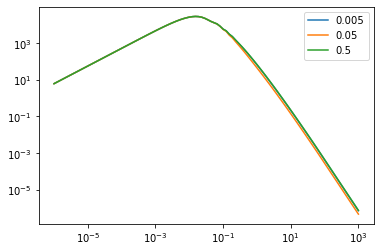

In [7]:
k_vals = np.logspace(-6, 3, 100)
plt.loglog(k_vals, lin_power[0](k_vals),label='0.005')
plt.loglog(k_vals, lin_power[1](k_vals),label='0.05')
plt.loglog(k_vals, lin_power[2](k_vals),label='0.5')
plt.legend()

#### `growth` plot

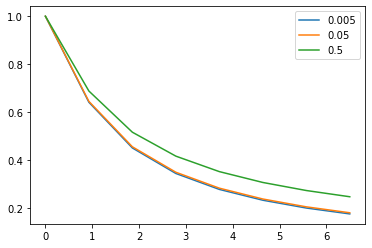

In [34]:
z_vals=np.linspace(0, 6.5, 8)
plt.plot(z_vals, growth[0](1e0, z_vals),label='0.005')
plt.plot(z_vals, growth[1](1e0, z_vals),label='0.05')
plt.plot(z_vals, growth[2](1e0, z_vals),label='0.5')
plt.legend()

#### Normal $\sigma$ and FFT $\sigma$ plot as a function of mass for $m$ ranging from $10^6 M_{\text{sun}}$ to $10^{16} M_{\text{sun}}$

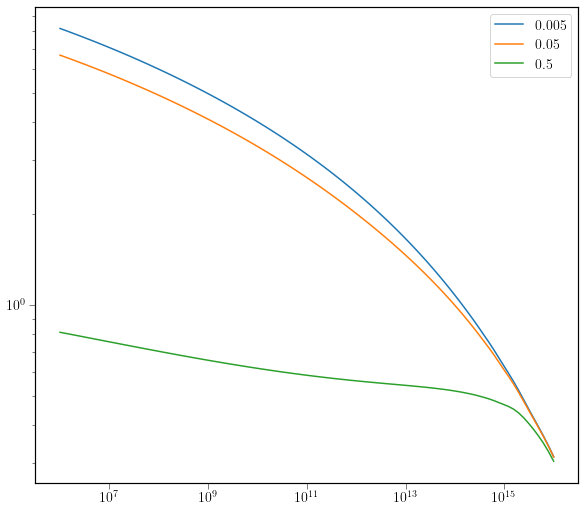

In [107]:
m_vals = np.logspace(6, 16, 100)
plt.loglog(m_vals, sigmaIntFFT[0](m_vals, 0.0),label='0.005')
plt.loglog(m_vals, sigmaIntFFT[1](m_vals, 0.0),label='0.05')
plt.loglog(m_vals, sigmaIntFFT[2](m_vals,0.0),label='0.5')
plt.legend()


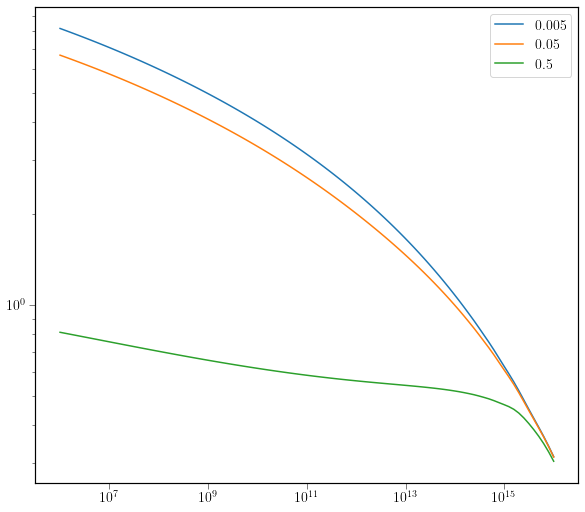

In [108]:
m_vals = np.logspace(6, 16, 100)
plt.loglog(m_vals, sigmaInt[0](m_vals, 0.0),label='0.005')
plt.loglog(m_vals, sigmaInt[1](m_vals, 0.0),label='0.05')
plt.loglog(m_vals, sigmaInt[2](m_vals,0.0),label='0.5')
plt.legend()


#### Bubble mass function with FFT variance

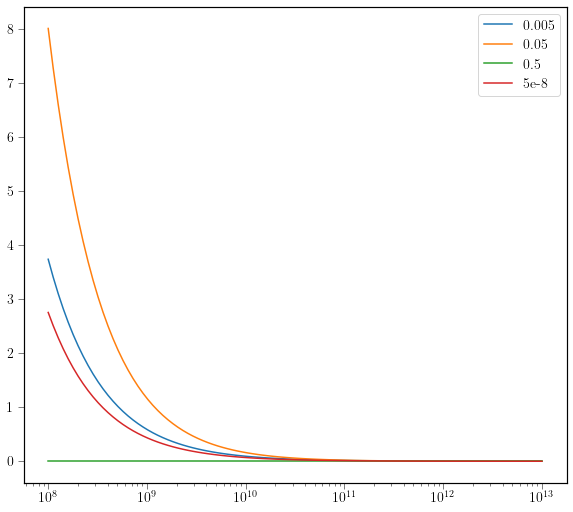

In [109]:
m_vals = np.logspace(8, 13, 100)
z = 12
plt.plot(m_vals, bubbleFuncFFT[0](m_vals,z),label='0.005')
plt.plot(m_vals, bubbleFuncFFT[1](m_vals,z),label='0.05')
plt.plot(m_vals, bubbleFuncFFT[2](m_vals,z),label='0.5')
plt.plot(m_vals, bubbleFuncFFT[3](m_vals,z),label='5e-8')
plt.xscale('log')
plt.legend()

#### Bubble mass function with normal variance

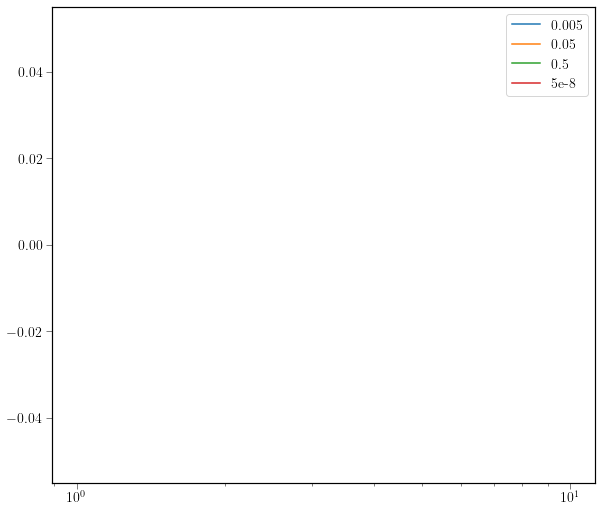

In [110]:
m_vals = np.logspace(8, 13, 100)
z = 12
plt.plot(m_vals, bubbleFunc[0](m_vals,z),label='0.005')
plt.plot(m_vals, bubbleFunc[1](m_vals,z),label='0.05')
plt.plot(m_vals, bubbleFunc[2](m_vals,z),label='0.5')
plt.plot(m_vals, bubbleFunc[3](m_vals,z),label='5e-8')
plt.xscale('log')
plt.legend()

#### Press-Schechter mass function with normal variance

[-1.21658536 -1.19638334 -1.17618132 -1.1559793  -1.13577728 -1.11557526
 -1.09537324 -1.07517122 -1.0549692  -1.03476718 -1.01456516 -0.99436314
 -0.97416112 -0.9539591  -0.93375708 -0.91355506 -0.89335304 -0.87315102
 -0.852949   -0.83274698 -0.81254496 -0.79234294 -0.77214092 -0.7519389
 -0.73173688 -0.71153486 -0.69133284 -0.67113082 -0.6509288  -0.63072678
 -0.61052476 -0.59032274 -0.57012072 -0.5499187  -0.52971668 -0.50951466
 -0.48931264 -0.46911062 -0.4489086  -0.42870657 -0.40850455 -0.38830253
 -0.36810051 -0.34789849 -0.32769647 -0.30749445 -0.28729243 -0.26709041
 -0.24688839 -0.22668637 -0.20648435 -0.18628233 -0.16608031 -0.14587829
 -0.12567627 -0.10547425 -0.08527223 -0.06507021 -0.04486819 -0.02466617
 -0.00446415  0.01573787  0.03593989  0.05614191  0.07634393  0.09654595
  0.11674797  0.13694999  0.15715201  0.17735403  0.19755605  0.21775807
  0.23796009  0.25816211  0.27836413  0.29856615  0.31876817  0.33897019
  0.35917221  0.37937423  0.39957625  0.41977827  0.

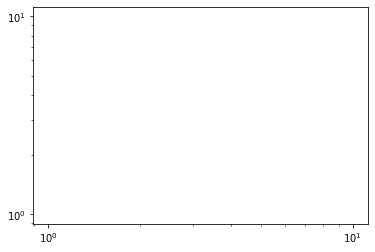

In [72]:
m_vals = np.logspace(9,15,100)
z = 6
plt.loglog(m_vals,pressSchechter[0](m_vals,z),label='0.005')
plt.loglog(m_vals,pressSchechter[1](m_vals,z),label='0.05')
plt.loglog(m_vals,pressSchechter[2](m_vals,z),label='0.5')
print(np.log10(sigmaInt[0].radius_of_mass(m_vals)))
print(sigmaInt[1](m_vals,z))
print(sigmaInt[2](m_vals,z))

#### Press-Schechter mass function with FFT variance

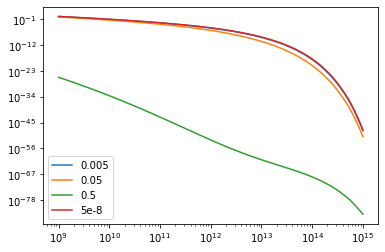

In [53]:
m_vals = np.logspace(9,15,100)
z = 6
plt.loglog(m_vals,pressSchechterFFT[0](m_vals,z),label='0.005')
plt.loglog(m_vals,pressSchechterFFT[1](m_vals,z),label='0.05')
plt.loglog(m_vals,pressSchechterFFT[2](m_vals,z),label='0.5')
plt.loglog(m_vals,pressSchechterFFT[3](m_vals,z),label='5e-8')
plt.legend()

## Furlanetto Figure 2: Bubble distribution 

Function definitions to convert mass to/from radius 

In [14]:
def m_from_R(R,cosmo,h_adjust=False):
    rho = cosmo.rho_mean
    
    # Determining omega & h adjustments
    if h_adjust == True:
        rho /= cosmo.h**2

    return (4/3) * np.pi * R**3 * rho * (1+z)**3



def R_from_m(m,cosmo,h_adjust=False): 
    rho = cosmo.rho_mean
    
    # Determining omega & h adjustments
    if h_adjust == True:
        rho /= cosmo.h**2

    return (3*m/(4*np.pi*rho))**(1/3)

Plotting $\overline{Q}^{-1}V\frac{\text{d}n}{\text{d}\ln R}$

Q = 6.683781186367704e-11
Q = 1.4661191377067966e-10
Q = 3.0868136035788032e-53
Q = 4.918657522852663e-11
Q = 8.911964772673545e-11
Q = 4.7607491339152746e-11
Q = 1.2314911946075084e-75
Q = 9.214494944549913e-11
Q = 5.218239782043317e-11
Q = 1.8975717824354238e-11
Q = 1.4076756485213369e-87
Q = 5.628241393148613e-11


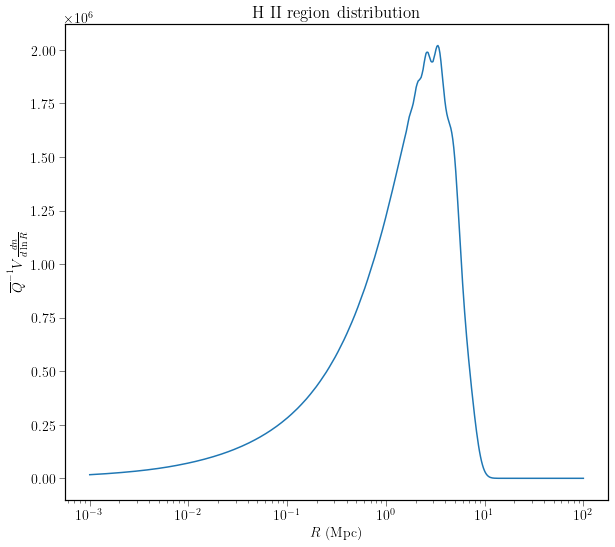

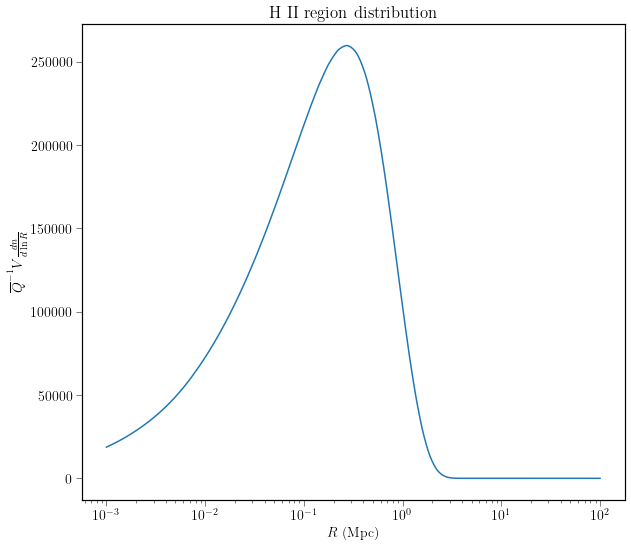

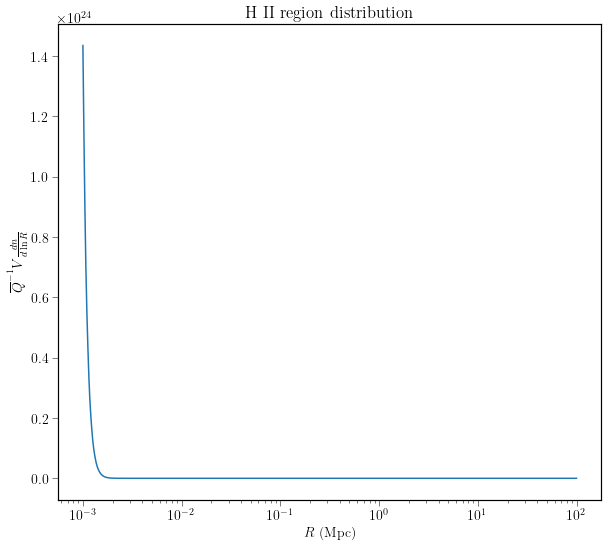

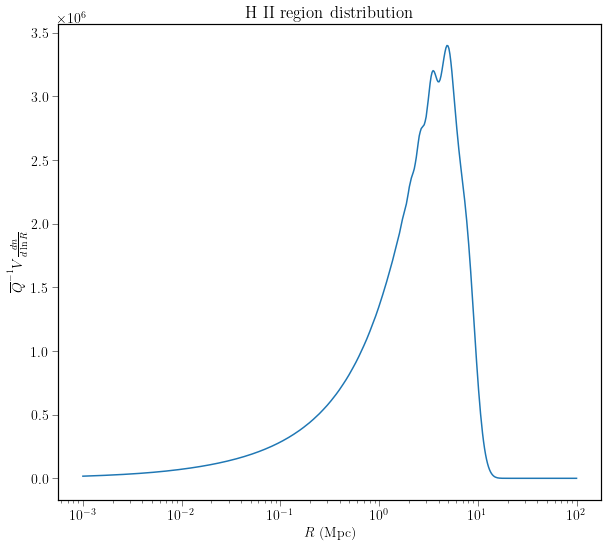

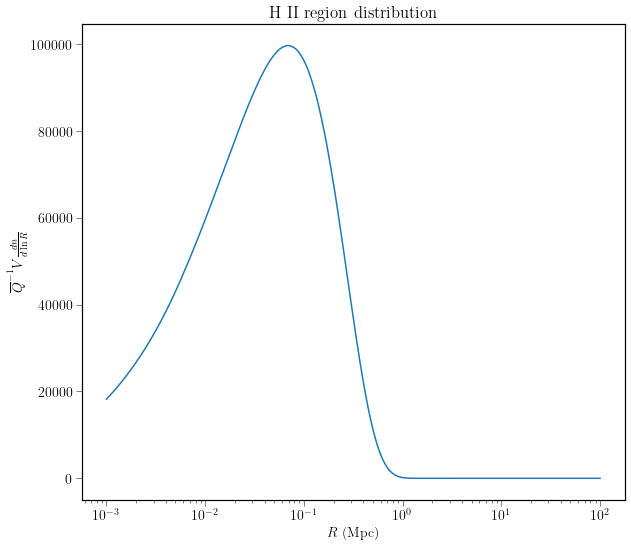

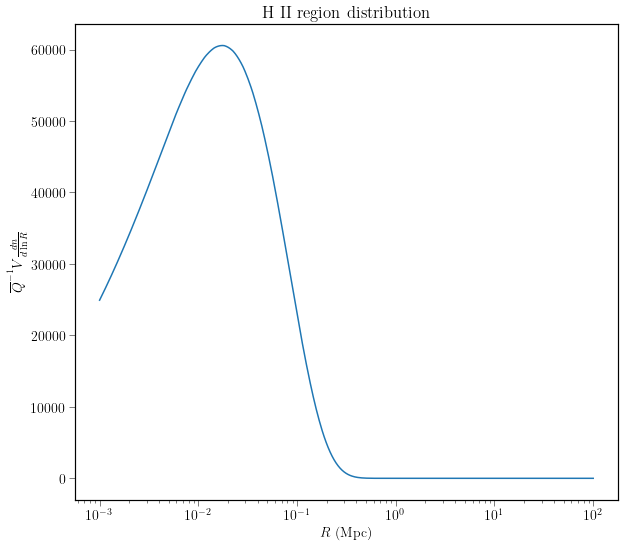

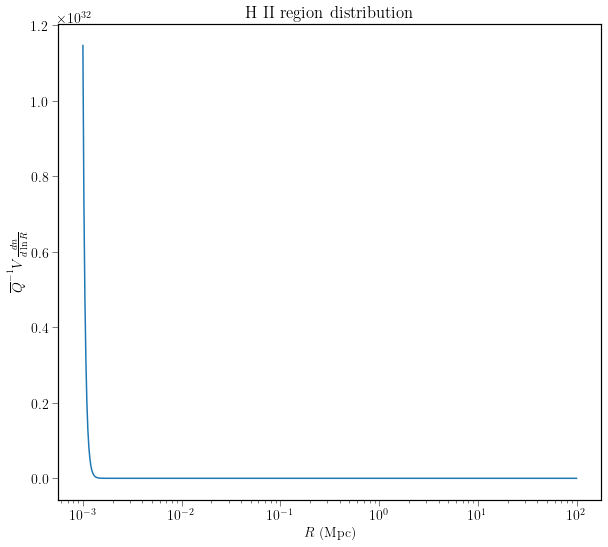

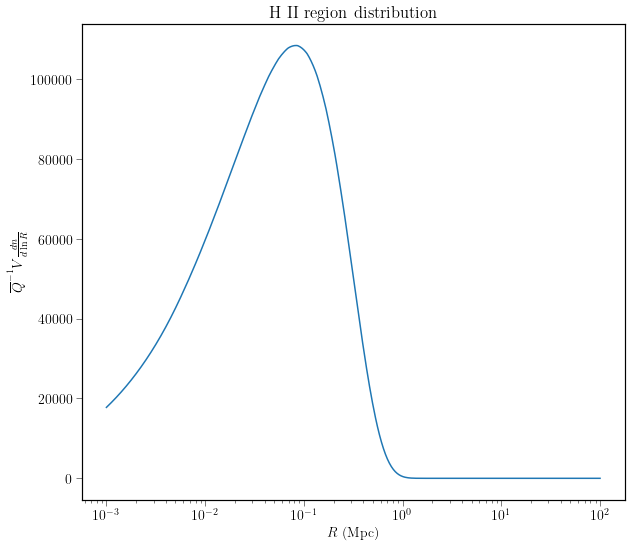

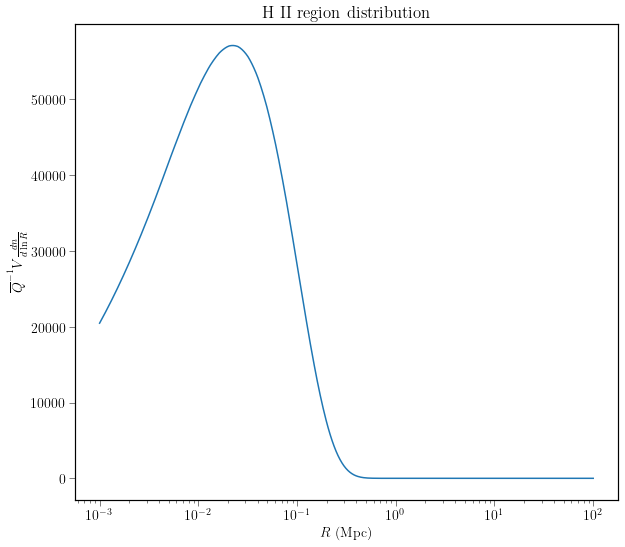

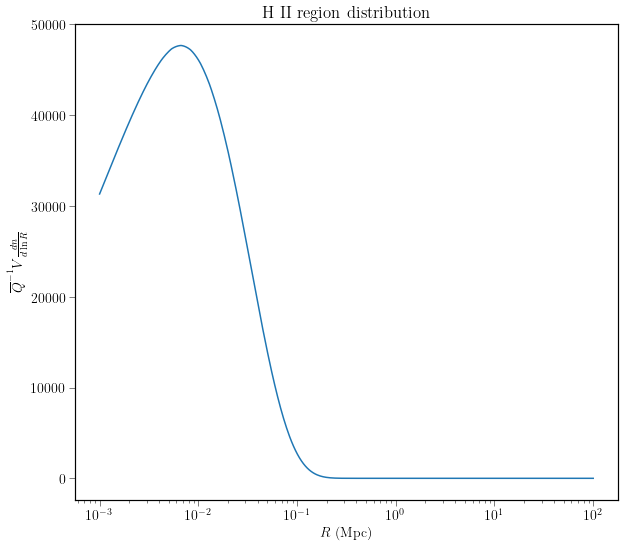

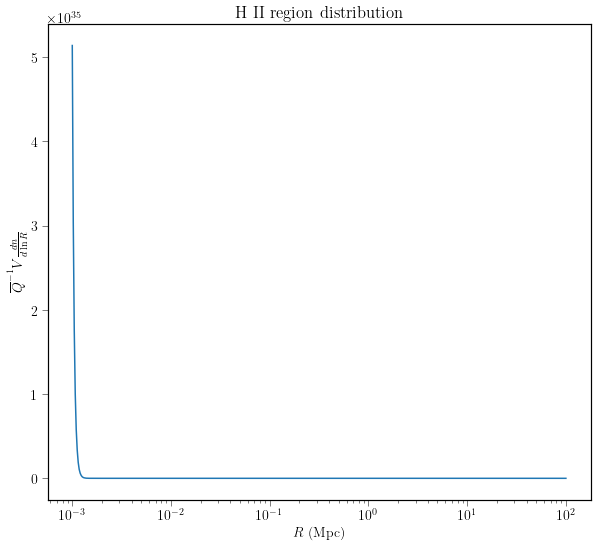

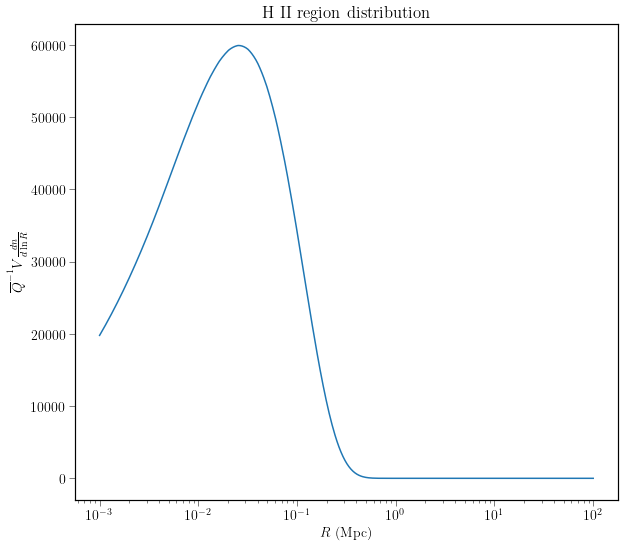

In [104]:
z_vals = [12,16,18]
zeta = 40

plt.rc('text',usetex=True)
plt.rc('font', **{'family':'serif','serif':['Times New Roman']})

for z in z_vals:
    for i in range(len(cosmos)):
        mMin = (1.308695e-10) * ((cosmos[i].RHO_C*1000 * cosmos[i].OmegaM)**(-1/2)) * ((1+z)**(-3/2)) * (1e4)**(3/2) # Included Delta in pre-eval w/ cosmology.py OmegaM property and in solar masses
#         mMin = (3.95284708e8/cosmos[i].h) * (1/(1+z))**(3/2)
        rho = cosmos[i].rho_mean * (1+z)**3
        integrand = lambda m: (1/rho) * bubbleFuncFFT[i](m,z)
        Q = quad(integrand,mMin,np.inf)[0]
        
        R_vals = np.logspace(-3,2,500)
        m_vals = (1/zeta)*m_from_R(R_vals,cosmos[i])
      
#         m_vals = np.logspace(np.log10(mMin),20,500)
#         R_vals = R_from_m(m_vals,cosmos[i])
        
        print("Q =",Q)
        title1 = f'H II region distribution'

        plt.figure()
        plt.plot(R_vals,3*(1/Q)*(m_vals/rho)*bubbleFuncFFT[i](m_vals,z))
#         plt.axvline(R_from_m(zeta*mMin,cosmos[i],z),c='black',linestyle='dashed')
        plt.xscale('log')
        plt.title(title1)
        plt.xlabel(r"$R$ (Mpc)")
        plt.ylabel(r"$\overline Q^{-1}V\frac{dn}{d\ln R}$")
        savename = f'QR_{i}_{z}.pdf'
        plt.savefig(savename)

## Testing integration methods

Want to get a stable method for determining $\overline{Q}$ that hopefully doesn't throw out a bunch of warnings.

#### Romberg

In [ ]:
# z_vals = [0,12,16,18]
z_vals = np.linspace(0,20,101)
# z_vals = [0]
zeta = 40
i=3
Q_vals = []
Q_vals_log = []

for z in z_vals:
#     mMin = (1.308695e-10) * ((cosmos[i].RHO_C*1000 * cosmos[i].OmegaM)**(-1/2)) * ((1+z)**(-3/2)) * (1e4)**(3/2) # Included Delta in pre-eval w/ cosmology.py OmegaM property and in solar masses
    mMin = (3.95284708e8/cosmos[i].h) * (1/(1+z))**(3/2)
#     mMin = 1e1
    log_mMin = np.log10(mMin)
    
    rho = cosmos[i].rho_mean * (1+z)**3
    
    integrand = lambda m: (1/rho) * pressSchechter[i](m,z)
    integrand_log = lambda m: (10**m/rho) * pressSchechter[i](10**m,z)
    
    Q_vals.append(romberg(integrand,mMin,1e24,divmax=10))
    Q_vals_log.append(romberg(integrand_log,log_mMin,24,divmax=10))
    
#     m_valslin = np.linspace(1,16,100)
#     m_valslog = np.logspace(1,16,100)
            

    
#     R_vals = np.logspace(-3,2,500)
#     m_vals = (1/zeta)*m_from_R(R_vals,cosmos[i])
#     print(bubbleFunc[i](m_vals,z))

#     m_vals = np.logspace(np.log10(mMin),20,500)
#     R_vals = R_from_m(zeta*m_vals,cosmos[i])

#     title1 = f'axion fraction = {cosmos[i].axion_frac}, z = {z}'

#     plt.figure()
#     plt.plot(R_vals,3*(1/Q)*(m_vals/rho) * pressSchechter[i](m_vals,z))
#         plt.axvline(R_from_m(zeta*mMin,cosmos[i],z),c='black',linestyle='dashed')
#     plt.xscale('log')
#     plt.title(title1)

plt.plot(z_vals,Q_vals)
plt.yscale('log')
plt.title('linear m')
plt.figure()

plt.plot(z_vals,Q_vals_log)
plt.yscale('log')
plt.title('logarithmic m')

## PS mass function plot

In [ ]:
# z_vals = [0,12,16,18]
z_vals = np.linspace(0,20,101)
# z_vals = [0]
zeta = 40
i=3
Q_vals = []
for z in z_vals:
    mMin = 1e1
    rho = cosmos[i].rho_mean * (1+z)**3
    
    if (10*z)%15 == 0:
            m_valslin = np.linspace(1,16,100)
            m_valslog = np.logspace(1,16,100)
            
            plt.figure(0)
            plt.plot(m_valslin,bubbleFunc[i](10**m_valslin,z),label=z)
            plt.figure(1)
            plt.loglog(m_valslog,bubbleFunc[i](m_valslog,z),label=z)
            
plt.figure(0)
plt.yscale('log')
plt.ylim([1e-16,1e7])
plt.legend()

plt.figure(1)
plt.ylim([1e-16,1e7])
plt.legend()

While the plots are generally looking like the right shape, the $Q$ values are *really* small, which would suggest that the space being considered is barely ionized at all. Furlanetto was getting values between 0.01 and 1. If I had to guess, perhaps the issue is either with how $m_{\text{min}}$ is calculated or the bubble function $m\frac{\text{d}n}{\text{d}m}$. Maybe changing the barrier from $\delta_c(z),\sigma(m)$ to $\delta_c,\sigma(m,z)$ doesn't work as nicely as I thought.

I also have noticed that Furlanetto uses Lagrangian coordinates, which other sources have talked about a bit, but I haven't been able to wrap my head around what that means or the implications of it. Is it something to be concerned about?

doi:10.1093/mnras/stw1542 (Q integral from $r_\text{min}$to $\infty$)

doi.org/10.48550/arXiv.1401.7994 (A bit on Euler/Lagrange coordinates, among other things)

doi:10.1093/mnras/stw1060

https://ned.ipac.caltech.edu/level5/Sept15/Johnson/Johnson1.html virial stuff

# III. Testing, Scratch, and Junk<a name="test"></a>

In [250]:
z = np.array([0,6,12,20])
mMin = (1.308695e-10) * ((cosmos[i].RHO_C*1000 * cosmos[i].OmegaM)**(-1/2)) * ((1+z)**(-3/2)) * (1e4)**(3/2) # Included Delta in pre-eval w/ cosmology.py OmegaM property and in solar masses
print(np.log10(mMin))
mMin = (3.95284708e8/cosmos[i].h) * (1/(1+z))**(3/2)
print(np.log10(mMin))


[9.26307159 7.99542453 7.59215656 7.27974265]
[8.73957752 7.47193046 7.06866249 6.75624858]


In [219]:
T = 1e4
m_min1 = (1e8/cosmo0.h) * (10/(1+z) * T/(4e4))**(3/2)
print(m_min1)
print(np.log10(m_min1))

11712847.480061824
7.068662488116533


C0 = 0.9586001449537348
B0 = [9.42484818 9.42501322 9.42518321 9.42535836 9.42553902 9.42572532
 9.42591757 9.42611606 9.4263211  9.42653307 9.42675218 9.42697874
 9.42721314 9.42745584 9.42770717 9.42796746 9.42823714 9.42851668
 9.4288066  9.42910738 9.42941933 9.42974309 9.4300792  9.43042834
 9.43079107 9.43116781 9.43155931 9.43196634 9.43238972 9.43282994
 9.43328768 9.43376382 9.43425925 9.43477487 9.43531117 9.43586894
 9.43644914 9.43705273 9.43768051 9.43833281 9.43901037 9.43971401
 9.44044446 9.44120199 9.44198638 9.44279791 9.44363671 9.44450272
 9.44539488 9.44631191 9.44725286 9.44821648 9.4492011  9.4502035
 9.45122077 9.45225021 9.45328871 9.45433262 9.45537661 9.45641644
 9.45744807 9.45846736 9.45946957 9.46044901 9.46140167 9.46232398
 9.46321274 9.46406423 9.46487501 9.46564317 9.46636733 9.46704663
 9.46768014 9.46826787 9.46881015 9.46930803 9.46976303 9.47017628
 9.47055053 9.47088777 9.47118951 9.47145925 9.47169972 9.47191211
 9.47209874 9.47226374 9.47240923 

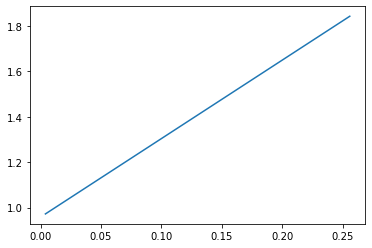

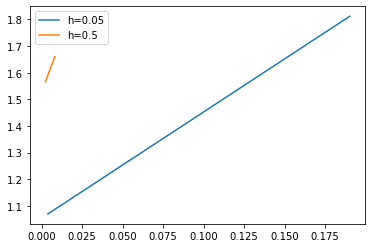

In [69]:
z = 12
m_vals = np.logspace(9,15,100)
s2_vals0 = sigmaInt[0](m_vals,z)**2
s2_vals1 = sigmaInt[1](m_vals,z)**2
s2_vals2 = sigmaInt[2](m_vals,z)**2

plt.plot(s2_vals0,bubbleFunc[0].B(m_vals,z),label='h=0.005')
plt.plot(s2_vals1,bubbleFunc[1].B(m_vals,z),label='h=0.05')
plt.plot(s2_vals2,bubbleFunc[2].B(m_vals,z),label='h=0.5')
plt.legend()

a = bubbleFunc[0](m_vals,z)
a = bubbleFunc[1](m_vals,z)
a = bubbleFunc[2](m_vals,z)

In [50]:
window = 'sharp_k'
intHelper = IntegrationHelper(2048)
z_vals_sigma = np.linspace(0,20,25) 

for i in range(len(cosmos)):
    sigmaInt[i] = SigmaInterpolator(cosmos[i],lin_power[i],growth[i],1e1,1e25,z_vals_sigma,intHelper,Nr=1024,window_function=window)
    sigmaInt[i].compute(1e-4,1e3)

In [117]:
mMin = (1.308695e-10) * ((cosmo0.RHO_C*1000 * cosmo0.OmegaM)**(-1/2)) * ((1+z)**(3/2)) * (1e4)**(3/2) # Included Delta in pre-eval w/ cosmology.py OmegaM property and in solar masses